# Rendering Triskaidecagrams

This notebook contains a program for rendering a triskaidecagon (13-sided regular polygon), together with all its inscribed triskaidecagrams.  My approach here consciously adopts a couple of constraints. First, I compute everything with exact arithmetic, using integers rather than floating point numbers.  Second, I compute intersection points by applying proportions, rather than by intersecting lines.

## Triskaidecagon Numbers

The first section of code below contains an implementation of the triskaidecagon number field, a field derived from the diagonals of the triskaidecagram as described in Steinbach2000 and Steinbach2004.  I use $\alpha$, $\beta$, $\gamma$, $\delta$, and $\epsilon$ for the diagonals of a unit-sided triskaidecagram, in order of increasing length.  Any field element has the form $a+b\alpha+c\beta+d\gamma+e\delta+f\epsilon$, for some rational numbers $a$, $b$, $c$, $d$, and $e$.

Given the table of basic products and reciprocals below, I can scale any number or vector up or down by factors of $\alpha$, $\beta$, $\gamma$, $\delta$, and $\epsilon$.  With this ability, I don't actually require general division, so I can limit my coefficients to integers rather than rationals.

|          | $\alpha$ | $\beta$ | $\gamma$ | $\delta$ | $\epsilon$ |
|----------|----------|---------|----------|----------|
| $\alpha$ | $\alpha\alpha=1+\beta$ | $\alpha\beta=\alpha+\gamma$ | $\alpha\gamma=\beta+\delta$ | $\alpha\delta=\gamma+\epsilon$ | $\alpha\epsilon=\delta+\epsilon$ |
| $\beta$  |         | $\beta\beta=1+\beta+\delta$ | $\beta\gamma=\alpha+\gamma+\epsilon$ | $\beta\delta=\beta+\delta+\epsilon$ | $\beta\epsilon=\gamma+\delta+\epsilon$ |
| $\gamma$ |         |         | $\gamma\gamma=1+\beta+\delta+\epsilon$ | $\gamma\delta=\alpha+\gamma+\delta+\epsilon$ | $\gamma\epsilon=\beta+\gamma+\delta+\epsilon$ |
| $\delta$ |         |         |         | $\delta\delta=1+\beta+\gamma+\delta+\epsilon$ | $\delta\epsilon=\alpha+\beta+\gamma+\delta+\epsilon$ |
| $\epsilon$ |         |         |         |         | $\epsilon\epsilon=1+\alpha+\beta+\gamma+\delta+\epsilon$ |

|  ratio  | inverse |
|----------|----------|---------|----------|----------|
| $1$ | $1/\theta=1+\theta-\kappa-\lambda+\mu$ | $1/\kappa=\theta+\kappa-\lambda-1$ | $1/\lambda=\lambda-\theta-1$ | $1/\mu=\mu-\lambda$ |
| $\theta$ |         | $\theta/\kappa=1+\lambda-\mu$ | $\theta/\lambda=\lambda-\theta-1$ | $\theta/\mu=\lambda-\kappa$ |
| $\kappa$  | $\kappa/\theta=\kappa+\lambda-\mu-1$ |     | $\kappa/\lambda=\mu-\kappa$ | $\kappa/\mu=\kappa-\theta$ |
| $\lambda$ | $\lambda/\theta=\kappa-1$ | $\lambda/\kappa=\theta+\mu-\lambda-1$ |  | $\lambda/\mu=\theta-1$ |
| $\mu$ | $\mu/\theta=1+\mu-\kappa$ | $\mu/\kappa=\lambda-\theta$ | $\mu/\lambda=\theta+\kappa-\mu$ |  $ $ |

All of these products and quotients can be derived using basic geometry, by considering various similar triangles in the triskaidecagon and inscribed triskaidecagrams.  I've explained the technique in more detail with respect to the [heptagon field](http://nbviewer.ipython.org/github/vorth/ipython/blob/master/heptagons/HeptagonNumbers.ipynb).

The code below is mostly a collection of special functions, to overload arithmetic operators for the class.  This will be very important for readability of the code later in the notebook.

In [477]:
import math

def addTermString( s, term, factor ):
    if term != 0 :
        if term < 0 :
            s = s + "-"
            term = -term
        else :
            if len(s) > 0 :
                s = s + "+"
        if term != 1 :
            s = s + "%d" % ( term )
        s = s + factor
    return s

class TriskaidecagonNumber(object):
    def __init__( self, ones=0, alpha=0, beta=0, gamma=0, delta=0, epsilon=0 ):
        self.ones = ones
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon

    def __add__( self, rhs ):  #self and rhs are TriskaidecagonNumber objects
        return TriskaidecagonNumber(
                self.ones+rhs.ones,
                self.alpha+rhs.alpha,
                self.beta+rhs.beta,
                self.gamma+rhs.gamma,
                self.delta+rhs.delta,
                self.epsilon+rhs.epsilon )

    def __sub__( self, rhs ):  #self and rhs are TriskaidecagonNumber objects
        return TriskaidecagonNumber(
                self.ones-rhs.ones,
                self.alpha-rhs.alpha,
                self.beta-rhs.beta,
                self.gamma-rhs.gamma,
                self.delta-rhs.delta,
                self.epsilon-rhs.epsilon )

    def __neg__( self ) :
        return TriskaidecagonNumber( -self.ones, -self.alpha, -self.beta, -self.gamma, -self.delta, -self.epsilon )

    def timesalpha( self ) :
        return TriskaidecagonNumber(
                self.alpha,
                self.ones + self.beta,
                self.alpha + self.gamma,
                self.delta + self.beta,
                self.epsilon + self.gamma,
                self.delta + self.epsilon )

    def timesbeta( self ) :
        return TriskaidecagonNumber(
                self.beta,
                self.alpha + self.gamma,
                self.ones + self.beta + self.delta,
                self.alpha + self.gamma + self.epsilon,
                self.delta + self.beta + self.epsilon,
                self.delta + self.gamma + self.epsilon )

    def timesgamma( self ) :
        return TriskaidecagonNumber(
                self.gamma,
                self.beta + self.delta,
                self.alpha + self.gamma + self.epsilon,
                self.beta + self.delta + self.ones + self.epsilon,
                self.alpha + self.gamma + self.epsilon + self.delta,
                self.beta + self.delta + self.gamma + self.epsilon )

    def timesdelta( self ) :
        return TriskaidecagonNumber(
                self.delta,
                self.gamma + self.epsilon,
                self.beta + self.delta + self.epsilon,
                self.alpha + self.gamma + self.delta + self.epsilon,
                self.ones + self.beta + self.gamma + self.delta + self.epsilon,
                self.alpha + self.beta + self.gamma + self.delta + self.epsilon )

    def timesepsilon( self ) :
        return TriskaidecagonNumber(
                self.epsilon,
                self.delta + self.epsilon,
                self.gamma + self.delta + self.epsilon,
                self.beta + self.gamma + self.delta + self.epsilon,
                self.alpha + self.beta + self.gamma + self.delta + self.epsilon,
                self.ones + self.alpha + self.beta + self.gamma + self.delta + self.epsilon )

    def __mul__( self, rhs ) :
        if isinstance( rhs, self.__class__ ):
            return ( self * rhs.ones ) .__add__(
                ( self .timesalpha() * rhs.alpha ) .__add__(
                ( self .timesbeta() * rhs.beta ) .__add__(
                ( self .timesgamma() * rhs.gamma ) .__add__(
                ( self .timesdelta() * rhs.delta ) .__add__(
                ( self .timesepsilon() * rhs.epsilon ) ) ) ) ) )
        elif isinstance( rhs, int ):
            return TriskaidecagonNumber(
                self.ones*rhs,
                self.alpha*rhs,
                self.beta*rhs,
                self.gamma*rhs,
                self.delta*rhs,
                self.epsilon*rhs )
        else:
            raise TypeError("unsupported operand type(s) for +: '{}' and '{}'").format(self.__class__, type(other))

    def __str__( self ):
        s = ""
        if self.ones != 0 :
            s = s + "%d" % ( self.ones )
        s = addTermString( s, self.alpha, "\u03B1" )
        s = addTermString( s, self.beta, "\u03B2" )
        s = addTermString( s, self.gamma, "\u03B3" )
        s = addTermString( s, self.delta, "\u03B4" )
        s = addTermString( s, self.epsilon, "\u03B5" )
        if ( len(s) == 0 ) :
            return "0"
        return s

    denom = math.sin( math.pi/13 )
    alpha_real = math.sin( 2*math.pi/13 ) / denom
    beta_real = math.sin( 3*math.pi/13 ) / denom
    gamma_real = math.sin( 4*math.pi/13 ) / denom
    delta_real = math.sin( 5*math.pi/13 ) / denom
    epsilon_real = math.sin( 6*math.pi/13 ) / denom
    
    def __float__( self ) :
        return self.ones + \
            self.alpha_real * self.alpha + \
            self.beta_real * self.beta + \
            self.gamma_real * self.gamma + \
            self.delta_real * self.delta + \
            self.epsilon_real * self.epsilon

zero    = TriskaidecagonNumber()
one     = TriskaidecagonNumber(1)
alpha   = TriskaidecagonNumber(0,1)
beta    = TriskaidecagonNumber(0,0,1)
gamma   = TriskaidecagonNumber(0,0,0,1)
delta   = TriskaidecagonNumber(0,0,0,0,1)
epsilon = TriskaidecagonNumber(0,0,0,0,0,1)

alpha_inv = alpha + beta + epsilon - delta - gamma - one
beta_inv = beta + gamma - alpha - delta
gamma_inv = one + gamma - epsilon
delta_inv = delta + gamma - one - alpha - epsilon
epsilon_inv = epsilon - delta

print( str(alpha)   + " = " + str(TriskaidecagonNumber.alpha_real) )
print( str(beta)    + " = " + str(TriskaidecagonNumber.beta_real) )
print( str(gamma)   + " = " + str(TriskaidecagonNumber.gamma_real) )
print( str(delta)   + " = " + str(TriskaidecagonNumber.delta_real) )
print( str(epsilon) + " = " + str(TriskaidecagonNumber.epsilon_real) )

def printProd( h1, h2 ) :
    print( str(h1) + " * "+ str(h2) + " = " + str(h1*h2) )
    
printProd( gamma, epsilon )
printProd( delta, beta )
printProd( gamma, gamma )
printProd( alpha, gamma )
printProd( delta, epsilon )
printProd( delta, 4 )
printProd( alpha, alpha_inv )


α = 1.941883634852104
β = 2.77091205130642
γ = 3.4389051311943066
δ = 3.907041544768732
ε = 4.148114905279378
γ * ε = β+γ+δ+ε
δ * β = β+δ+ε
γ * γ = 1+β+δ+ε
α * γ = β+δ
δ * ε = α+β+γ+δ+ε
δ * 4 = 4δ
α * -1+α+β-γ-δ+ε = 1


## Vectors and Rendering

The next section of code is a simple implementation of two-dimensional vectors over the triskaidecagon numbers.  The only noteworthy point here is the render function, which does two things.  First, it converts the coordinate triskaidecagon numbers to real numbers.  Next, it performs a skew transformation to map from the initial coordinate frame to the frame I need to use for drawing.  These coordinate frames are different because the first one allows a simple encoding of the triskaidecagon vertices, using a frame aligned with a diagonal of the triskaidecagon.  This simplifies all the later computations based on these vertices.  The only cost is to perform the skew transformation when it is time to render to the screen.


In [478]:

class Vector(object):

    def __init__( self, x, y ):
        self.x = x
        self.y = y

    def __mul__( self, rhs ) :
        return Vector( rhs .__mul__( self.x ), rhs .__mul__( self.y ) )

    def __add__( self, rhs ) :
        return Vector( self.x + rhs.x, self.y + rhs.y )

    def __sub__( self, rhs ) :
        return Vector( self.x - rhs.x, self.y - rhs.y )

    def __neg__( self ) :
        return Vector( -self.x, -self.y )

    def __str__( self ):
        return "[ " + str( self.x ) + ", " + str( self.y ) + " ]"

    def render( self, offset=( 0.0, 0.0 ), scale=1.0 ):
        x = float( self.x )
        y = float( self.y )
        A = math.sin( (6.0/13.0) * math.pi )
        x = float( self.x ) + float( self.y ) / (2*TriskaidecagonNumber.epsilon_real)
        y = A * float( self.y )
        x_off, y_off = offset
        return [ scale*x + x_off, scale*y + y_off ]

origin = Vector( zero, zero )

str( Vector( beta, gamma ) )


'[ β, γ ]'

## Triskaidecagon Vertices

The code below defines the vertices of the triskaidecagon, then constructs lists of those vertices representing the triskaidecagon and all of the inscribed triskaidecagrams (stars).

In [479]:

p = [ Vector( one, zero ) for x in range(13) ]
p[0] = Vector( zero, zero )
p[1] = Vector( - delta, alpha )
p[2] = Vector( - beta - delta, alpha + gamma )
p[3] = Vector( - one - beta - delta, gamma * beta )
p[4] = Vector( - beta - delta, gamma * delta )
p[5] = Vector( - delta, delta * epsilon )
p[6] = Vector( zero, epsilon * epsilon )
p[7] = Vector( epsilon, delta * epsilon )
p[8] = Vector( gamma + epsilon, gamma * delta )
p[9] = Vector( gamma * beta, gamma * beta )
p[10] = Vector( gamma * beta, alpha + gamma )
p[11] = Vector( gamma + epsilon, alpha )
p[12] = Vector( epsilon, zero )

triskaidecagrams = [ [ p[ (n * m) % 13 ] for m in range(13) ] for n in range(7) ]


## Drawing


In [480]:
%pylab --no-import-all inline

def polygonPath( polygonVerts, offset=( 0.0, 0.0 ), scale=1.0 ):
    n = len( polygonVerts )
    codes = [ Path.MOVETO ]
    verts = []
    verts .append( polygonVerts[ 0 ] .render( offset, scale ) )
    for i in range(1,n+1):
        codes.append ( Path.LINETO )
        verts.append ( polygonVerts[ i % n ] .render( offset, scale ) )
    return matplotlib.path.Path( verts, codes )

def vertexRayPath( offset=( 0.0, 0.0 ), scale=1.0 ):
    codes = []
    verts = []
    for i in range(1,13):
        codes .append( Path.MOVETO )
        verts .append( p[ 0 ] .render( offset, scale ) )
        codes .append( Path.LINETO )
        verts .append( p[ i ] .render( offset, scale ) )
    return mpath.Path( verts, codes )



Populating the interactive namespace from numpy and matplotlib


## Design Parameters

My intention is to produce a design of thirteen copies of a polygon constructed from sections of diagonals of the triskaidecagon.  Each polygon should use only one of each type of diagonal, to insure that the thirteen loops intersect each other without edge overlaps - all vertices of all the loops should be visible.  The polygon can be non-convex, and even self-intersecting.

## Indexing

A key to the entire endeavor is a scheme for identifying diagonals and their intersections.  Obviously, the vertices of the triskaidecagon can be numbered from zero to twelve, as shown above.  (Zero-based indexing is far superior for doing modular arithmetic.)  Furthermore, any diagonal can be given the name "(m,n)", where m < n, for vertex numbers m and n.  The type of the diagonal (which dictates its length) is simply n-m.  This means that an edge of the triskaidecagon is a "type 1" diagonal, since it joins two adjacent vertex indices.

Each vertex of the triskaidecagon actually has twelve incident diagonals, one to every other vertex.  There are two of every length, of course, but I want to treat those two as distinct, since that simplifies the code.  I will therefore number diagonal types from 0 to 12, and understand that diagonal type 0 is degenerate.

An intersection of two diagonal can be named based on the names of the diagonals.  Since I'm only interested in intersections that lie inside the triskaidecagon, I will name intersections as "(a,b,c,d)", where a < b < c < d, and the diagonals intersecting are (a,c) and (b,d)

In [481]:

D = [ zero for x in range(13) ]
D[1] = D[12] = one
D[2] = D[11] = alpha
D[3] = D[10] = beta
D[4] = D[9] = gamma
D[5] = D[8] = delta
D[6] = D[7] = epsilon

for i in range(13):
    print( "D[" + str(i) + "] = " + str(D[i]) )

I = [ zero for x in range(13) ] # technically, I[0] should be NaN
I[1] = I[12] = one
I[2] = I[11] = alpha_inv
I[3] = I[10] = beta_inv
I[4] = I[9] = gamma_inv
I[5] = I[8] = delta_inv
I[6] = I[7] = epsilon_inv

for i in range(13):
    print( "I[" + str(i) + "] = " + str(I[i]) )


D[0] = 0
D[1] = 1
D[2] = α
D[3] = β
D[4] = γ
D[5] = δ
D[6] = ε
D[7] = ε
D[8] = δ
D[9] = γ
D[10] = β
D[11] = α
D[12] = 1
I[0] = 0
I[1] = 1
I[2] = -1+α+β-γ-δ+ε
I[3] = -α+β+γ-δ
I[4] = 1+γ-ε
I[5] = -1-α+γ+δ-ε
I[6] = -δ+ε
I[7] = -δ+ε
I[8] = -1-α+γ+δ-ε
I[9] = 1+γ-ε
I[10] = -α+β+γ-δ
I[11] = -1+α+β-γ-δ+ε
I[12] = 1


In [482]:

def diagonalIntersectionPath( p, a, b, c, d, color ):
    inter = diagonalIntersection( p, a, b, c, d )
    codes = []
    verts = []
    codes .append( Path.MOVETO )
    verts .append( p[ a ] .render() )
    codes .append( Path.LINETO )
    verts .append( inter .render() )
    codes .append( Path.MOVETO )
    verts .append( p[ b ] .render() )
    codes .append( Path.LINETO )
    verts .append( inter .render() )
    codes .append( Path.MOVETO )
    verts .append( p[ c ] .render() )
    codes .append( Path.LINETO )
    verts .append( inter .render() )
    codes .append( Path.MOVETO )
    verts .append( p[ d ] .render() )
    codes .append( Path.LINETO )
    verts .append( inter .render() )
    return mpath.Path( verts, codes )



## Computing Diagonal Intersections

The ```diagonalIntersection``` function computes the intersection point for any two
diagonals of the triskaidecagon.  Each diagonal is encoded as a pair of vertex indices,
representing the endpoints of the diagonal.  Diagonal (ab) is the same as diagonal (ba).
All index computation is done modulo N.
The intersection computation is simple, based on similar triangles.  (Need a figure here!)
It is based on the fact that all angles in the triskaidecagon (with all diagonals) are multiples of $\pi/13$.  For the angle subtended between any two diagonals meeting at a vertex,
it is sufficient to subtract the indices of the two vertices at the opposite ends of the diagonals.  If you know those numbers for three angles of a triangle, you know the shape of the triangle:

In [483]:

def diagonalIntersection( p, a, b, c, d ):
    # a, c = indices of endpoints of one diagonal
    # b, d = indices of endpoints of other diagonal
    # For internal diagonals, require that a < b < c < d
    n = len( p )
    e = ( d - a ) % n
    f = ( n - ( b + d ) + ( a + c ) ) % n
    g = ( b - a ) % n
    h = ( c - a ) % n
    return p[a] + ( p[c] - p[a] ) * D[e] * D[g] * I[f] * I[h]
    
str( diagonalIntersection( p, 1, 2, 4, 8 ))

'[ 1-β-γ-δ+ε, -1+γ+δ ]'

In [484]:
import random

def diagonalIntersectionLoop( n, used=[] ):
    loop = []
    edges = (n-1)/2
    a = random .randint( 0, n-1 )
    b = random .randint( a+2, n-1+a-2 ) % n
    a0 = a
    b0 = b
    print( "a: " + str(a) + ", b: " + str(b) )
    loop .append( ( a, b ) )
    for i in range(2,(n)//2):
        print( "i = " + str(i) )
        if ( b < a ):
            swap = b
            b = a
            a = swap
        diff = (b-a)%n
        if diff > edges:
            diff = n-diff
        #used[ diff-1 ] = True
        # now a < b
        c = random .randint( a+1, b-1 ) % n
        d = random .randint( b+1, a-1+n ) % n
        print( "c: " + str(c) + ", d: " + str(d) )
        loop .append( ( c, d ) )
        a = c
        b = d
    return loop

def loopPoints( loop, offset, N ):
    points = []
    n = len(loop)
    for i in range( n ):
        a, b = loop[ i ]
        c, d = loop[ (i+1)%n ]
        a = ( a + offset ) % N
        b = ( b + offset ) % N
        c = ( c + offset ) % N
        d = ( d + offset ) % N
        pt = diagonalIntersection( p, a, c, b ,d )
        points .append( pt )
    return points

## Scaled Triskaidecagons

It is not immediately evident, but the diagonal intersections contain the vertices of many scaled-down triskaidecagons, or rather parts of them.

In [485]:

def innerNgonPaths1( offset=( 0.0, 0.0 ), scale=1.0 ) :
    paths = []
    for i in range(0,6):
        codes = [ Path.MOVETO ]
        verts = [ p[0] .render( offset, scale ) ]
        for j in range(1,7):
            codes .append( Path.LINETO )
            intersection = diagonalIntersection( p, 0, j, 6-i+j, 12-i )
            verts .append( intersection .render( offset, scale ) )
        paths .append( mpath.Path( verts, codes ) )
    return paths

def innerNgonPaths2( offset=( 0.0, 0.0 ), scale=1.0 ) :
    paths = []
    for i in range(0,6):
        codes = [ Path.MOVETO ]
        verts = [ p[0] .render( offset, scale ) ]
        for j in range(0,7):
            codes .append( Path.LINETO )
            intersection = diagonalIntersection( p, 0, i, 6+i-j, 12-j )
            verts .append( intersection .render( offset, scale ) )
        paths .append( mpath.Path( verts, codes ) )
    return paths


## Sticker Cut Line


In [486]:

def stickerCutPath( offset, scale ) :
    verts = []

    for i in range(13) :
        R = diagonalIntersection( p, (i+4)%13, (i+6)%13, (i+8)%13, (i+10)%13 )
        S = diagonalIntersection( p, (i+2)%13, (i+6)%13, (i+7)%13, (i+9)%13 )
        T = diagonalIntersection( p, (i+5)%13, (i+6)%13, (i+8)%13, (i+9)%13 )
        U = diagonalIntersection( p, (i+5)%13, (i+7)%13, (i+8)%13, (i+12)%13 )
        Y = p[(i+6)%13] + p[(i+8)%13] - R
        Z = Y + T - S
        X = Y + T - U
        verts .append( X .render( offset, scale ) )
        verts .append( Y .render( offset, scale ) )
        verts .append( Z .render( offset, scale ) )
    verts .append( verts[0] ) # close the path
    
    codes = [mpath.Path.MOVETO]
    for i in range(13) :
        codes .append( mpath.Path.CURVE3 )
        codes .append( mpath.Path.CURVE3 )
        codes .append( mpath.Path.LINETO )
    
    return mpath.Path(verts, codes)


In [487]:

right = 5.5
top = 8.5
left = bottom = 0.0
eighth = 0.125
cutleft = 0.0 + eighth
cutright = right - eighth
cutbottom = 0.0 + eighth
cuttop = top - eighth

verts = [(cutleft+eighth, cutbottom),
         (cutright-eighth, cutbottom), # start of the lower right corner
         (cutright, cutbottom), # intermediate point (as if it wasn't rounded)
         (cutright, cutbottom+eighth), # end point of the lower right corner
         (cutright, cuttop-eighth), # move to the next point etc.
         (cutright, cuttop),
         (cutright-eighth, cuttop),
         (cutleft+eighth, cuttop),
         (cutleft, cuttop),
         (cutleft, cuttop-eighth),
         (cutleft, cutbottom+eighth),
         (cutleft, cutbottom),
         (cutleft+eighth, cutbottom)]

codes = [mpath.Path.MOVETO,
         mpath.Path.LINETO,
         mpath.Path.CURVE3,
         mpath.Path.CURVE3,
         mpath.Path.LINETO,
         mpath.Path.CURVE3,
         mpath.Path.CURVE3,
         mpath.Path.LINETO,
         mpath.Path.CURVE3,
         mpath.Path.CURVE3,
         mpath.Path.LINETO,
         mpath.Path.CURVE3,
         mpath.Path.CURVE3]


sheet_cut_line = mpath.Path(verts, codes)


In [488]:

def colorLoop( i, N ) :
    theta = 2*i*math.pi/N
    r = 0.6 + 0.3 * math.sin( theta )
    g = 0.6 + 0.3 * math.sin( theta + 2*math.pi/3 )
    b = 0.5 + 0.3 * math.sin( theta + 3*math.pi/3 )
    return ( r, g, b )

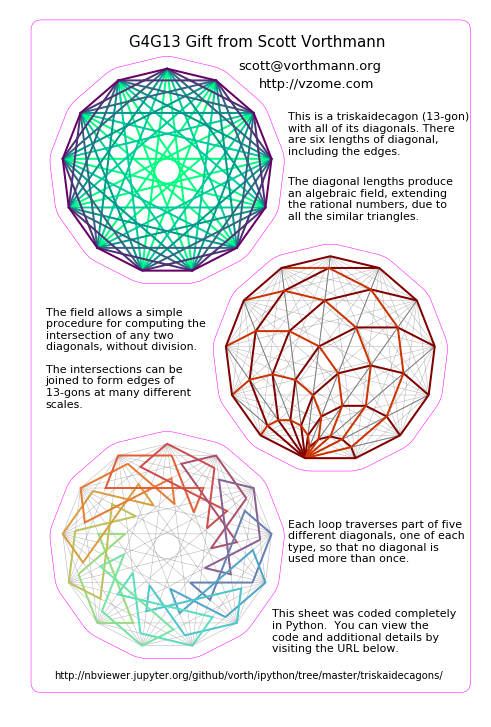

In [489]:

fig = matplotlib.pyplot.figure( figsize=(right*1.5,top*1.5) )
#matplotlib.artist.getp(fig.patch)

ax = fig.add_subplot(111)
#matplotlib.artist.getp(ax.patch)

ax.set_xlim(left,right)
ax.set_ylim(bottom,top)

patch = matplotlib.patches.PathPatch( sheet_cut_line, fc='none', ec=(1.0,0,1.0), lw=0.5 )
ax.add_patch( patch )

SCALE = 0.145

ax.text( 1.3, 8.2, "G4G13 Gift from Scott Vorthmann",
        verticalalignment='top', horizontalalignment='left',
        fontsize=15)

ax.text( 2.6, 7.9, "scott@vorthmann.org",
        verticalalignment='top', horizontalalignment='left',
        fontsize=13)

ax.text( 2.85, 7.67, "http://vzome.com",
        verticalalignment='top', horizontalalignment='left',
        fontsize=13)

ax.text( 0.4, 0.4, "http://nbviewer.jupyter.org/github/vorth/ipython/tree/master/triskaidecagons/",
        verticalalignment='top', horizontalalignment='left',
        fontsize=10)

text = """
This is a triskaidecagon (13-gon)
with all of its diagonals. There
are six lengths of diagonal,
including the edges.
"""
ax.text( 3.2, 7.4, text,
        verticalalignment='top', horizontalalignment='left',
        fontsize=11)

text = """
The diagonal lengths produce
an algebraic field, extending
the rational numbers, due to
all the similar triangles.
"""
ax.text( 3.2, 6.6, text,
        verticalalignment='top', horizontalalignment='left',
        fontsize=11)

text = """
The field allows a simple
procedure for computing the
intersection of any two
diagonals, without division.
"""
ax.text( 0.3, 5.0, text,
        verticalalignment='top', horizontalalignment='left',
        fontsize=11)

text = """
The intersections can be
joined to form edges of
13-gons at many different
scales.
"""
ax.text( 0.3, 4.3, text,
        verticalalignment='top', horizontalalignment='left',
        fontsize=11)

text = """
Each loop traverses part of five
different diagonals, one of each
type, so that no diagonal is
used more than once.
"""
ax.text( 3.2, 2.4, text,
        verticalalignment='top', horizontalalignment='left',
        fontsize=11)

text = """
This sheet was coded completely
in Python.  You can view the
code and additional details by
visiting the URL below.
"""
ax.text( 3.0, 1.3, text,
        verticalalignment='top', horizontalalignment='left',
        fontsize=11)

offset = ( 1.45, 5.3 )

path = stickerCutPath( offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(1.0,0,1.0), lw=0.5 )
ax.add_patch( patch )

path = polygonPath( triskaidecagrams[6], offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0,1.0,0.5), lw=2 )
ax.add_patch( patch )

path = polygonPath( triskaidecagrams[5], offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0,0.8,0.6), lw=2 )
ax.add_patch( patch )

path = polygonPath( triskaidecagrams[4], offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0,0.6,0.55), lw=2 )
ax.add_patch( patch )

path = polygonPath( triskaidecagrams[3], offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0.2,0.4,0.5), lw=2 )
ax.add_patch( patch )

path = polygonPath( triskaidecagrams[2], offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0.3,0.2,0.45), lw=2 )
ax.add_patch( patch )

path = polygonPath( triskaidecagrams[1], offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0.4,0,0.4), lw=2 )
ax.add_patch( patch )

offset = ( 3.4, 3.0 )

path = stickerCutPath( offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(1.0,0,1.0), lw=0.5 )
ax.add_patch( patch )

for i in range(7):
    path = polygonPath( triskaidecagrams[i], offset, SCALE )
    patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0.7,0.7,0.7), lw=0.5 )
    ax.add_patch( patch )

path = vertexRayPath( offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0.5,0.5,0.5), lw=1 )
ax.add_patch( patch )

for path in innerNgonPaths1( offset, SCALE ):
    patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0.5,0,0), lw=2 )
    ax.add_patch( patch )

for path in innerNgonPaths2( offset, SCALE ):
    patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0.8,0.2,0), lw=2 )
    ax.add_patch( patch )

path = polygonPath( triskaidecagrams[1], offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0.5,0,0), lw=2 )
ax.add_patch( patch )

offset = ( 1.45, 0.7 )

path = stickerCutPath( offset, SCALE )
patch = matplotlib.patches.PathPatch( path, fc='none', ec=(1.0,0,1.0), lw=0.5 )
ax.add_patch( patch )

for i in range(7):
    path = polygonPath( triskaidecagrams[i], offset, SCALE )
    patch = matplotlib.patches.PathPatch( path, fc='none', ec=(0.7,0.7,0.7), lw=0.5 )
    ax.add_patch( patch )

N = len( p )
loop = [ (10,12), (11,1), (7,12), (9,3), (6,10) ] # simpler loop
loop = [ (1,3), (2,7), (3,9), (4,13), (11,14) ]
for i in range( N ):
    path = polygonPath( loopPoints( loop, i, N ), offset, SCALE )
    patch = matplotlib.patches.PathPatch( path, fc='none', ec=colorLoop(i,N), lw=2 )
    ax.add_patch( patch )

ax.axis('off')
fig.savefig( "g4g13-sticker-sheet.pdf" )
